## 对卷积神经网络做可视化

通过对卷积神经网络的卷积层输出和卷积核进行可视化，可以观察到卷积网络学习到了什么。可视化的方法有很多，这里记录两种我已经搞明白咋回事的，其他方法以后再补充。

### 对卷积层的输出进行可视化

每个卷积核作用在输入上都会产生一个输出，文献里把这个输出叫做 activation 。对各个输出进行可视化，能够看到卷积核是如何处理输入数据的。具体的做法就是，输入一张图片，然后记录下各卷积层各个输出通道的输出，然后将其可视化。

这里对此前训练 dog vs cat 模型的卷积层进行可视化。

**加载模型**

In [4]:
from keras.models import load_model
model = load_model('cats_and_dogs_small.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

**准备一张输入图片**

从文件系统获取一张图片作为网络的输入，这可以使用 `keras.preprocessing.image` 模块提供的一些方法。

In [5]:
from keras.preprocessing import image
import numpy as np

img_path = os.path.join(test_dir, 'cat/cat.1700.jpg')

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

# 因为输入的第一个维度为 batch-size，所以需要增加一个维度
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

img_tensor.shape

(1, 150, 150, 3)

**可视化输入**

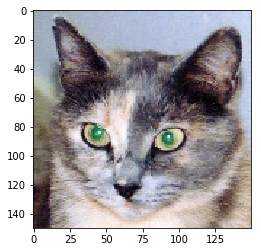

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0])

**构建从输入到各卷积层输出的模型**

为了获得各个卷积层的输出，需要构建一个从输入到输出的模型。使用 keras 的 `models.Model` 类可以轻松完成此任务。提供一组 `input` 和一组 `output` 作为参数，`Model` 能够完成数据从输入到输出的流动，即，提供输入，得到输出。这样以来，就能够使用一张图片作为输入，得到多个卷积层的输出了。

In [14]:
from keras import models
import re

layer_outputs = [layer.output for layer in model.layers if re.search(r'conv2d', layer.name)]

activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

**获得各卷积层的输出**

使用 `predict` 方法，提供输入，得到输出。

4
(1, 148, 148, 32)


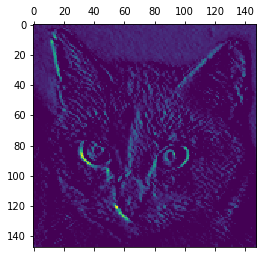

In [16]:
activations = activation_model.predict(img_tensor)

print(len(activations))

first_conv_activation = activations[0]
print(first_conv_activation.shape)

# 查看第 8 个卷积核对应的输出
plt.matshow(first_conv_activation[0, :, :, 8], cmap='viridis')

**对所有输出进行可视化**

这里把前面的步骤，封装在一个函数里。

In [18]:
from keras import models

def visualize_conv_activation(model, input_img_tensor, layer_selector=lambda x: True):
    layers = [layer for layer in model.layers if layer_selector(layer)]
    layer_outputs = [layer.output for layer in layers]
    layer_names = [layer.name for layer in layers]
    
    activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

    images_per_row = 16
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):

        # The feature map has shape (1, size, size, n_features)
        n_features = layer_activation.shape[-1]
        # 图片宽度
        size = layer_activation.shape[1]
        
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
    
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    
        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

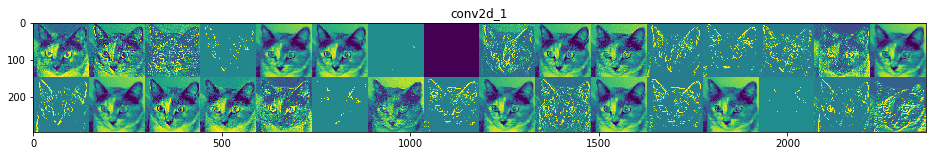

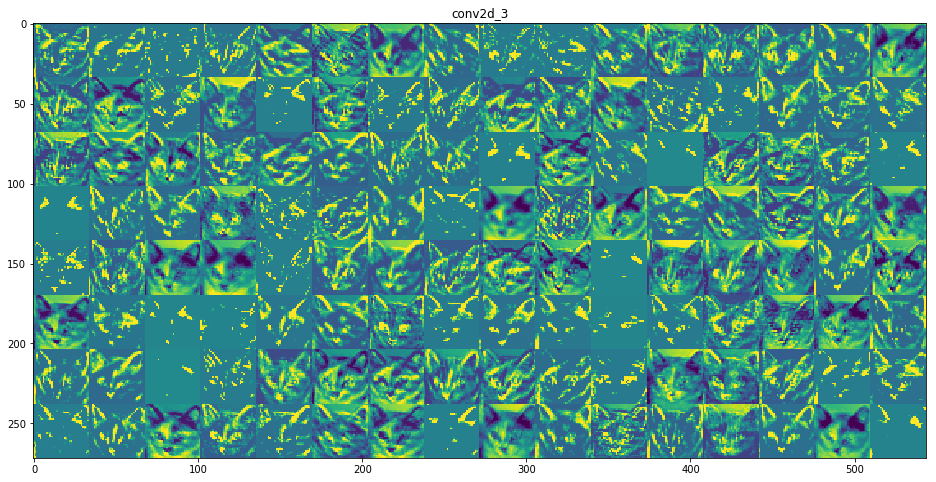

In [21]:
visualize_conv_activation(model, img_tensor, layer_selector=lambda layer: layer.name in ['conv2d_1','conv2d_3'])

可以看到，从前面的卷积层输出的内容中还能看到原图的影子，到了后面就看不出来了。因为后面的卷积层提取到的是更抽象的特征。

### 对卷积核进行可视化

不同的卷积核对输入中的不同特征有不同的响应程度，比如，有的卷积核对横向条纹敏感，有的可能对纵向条纹敏感。可以观察一下各个卷积核对什么特征有大的激活，这样就能知道这些卷积核能都提取什么特征了。

其大致思路是，调整输入图片，让该卷积核作用下得到的输出的值最大。因为卷积核是在输入图片上由左至右、由上至下移动着与输入产生作用，要想输出的每个位置上的值都最大，那么输入图片的各个位置都应该有能使卷积核产生大的输入的特征。

因此，可以使用卷积核作用下的输出的均值作为目标值，用该均值对输入求导，并以此更新输入。多次迭代，输入就变成了能使卷积核产生大的输出的样子了。

**导入卷积网络**

这里对 VGG16 模型的卷积核进行可视化，因为这个模型在 ImageNet 上已经训练的很好了，对它的卷积核可视化可能结果会更好一些。

In [2]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

**得到优化目标**

这里把卷积层输出的均值作为 loss，后面目标就是让这个 loss 最大化。这操作可以叫做 gradient ascent。

In [5]:
layer_name = 'block3_conv1'
filter_index = 5
layer_output = model.get_layer(layer_name).output

loss = K.mean(layer_output[:, :, :, filter_index])

**求输入的导数**

`keras.backend.gradients(loss, variables)` 的作用是对 loss 以 variables 求导。下面代码对模型的输入进行求导。

为了保证导数的不同维度的数值差异过大，这是对导数除上了其均值的开方。`+1e-5` 是为了避免除数为 0。

In [6]:
grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

**在迭代中更新输入**

`keras.backend.function(inputs, outputs, updates=None)`  我想是建立输入和输出的数据图，而后提供一个输入就能得到相应的输出。

初始化图片为像素值为 `128 +/- 20` 的图片，然后反复更新几十次。

In [7]:
import numpy as np

iterate = K.function([model.input], [loss, grads])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

loss_value, grads_value = iterate([input_img_data])
input_img_data += grads_value * step

print(grads_value.shape, loss_value)

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

print(grads_value.shape, loss_value)

(1, 150, 150, 3) 70.767426
(1, 150, 150, 3) 5826.8057


可以看到迭代后，loss 值变大了很多。

**可视化更新后的输入**

显示图片之前，应该对各像素值稍作调整。有的像素点可能已经在更新过程中远远超出了 `[0, 255]` 的范围，而且不同像素点的像素值可能差异巨大，直接可视化应该不会得到有意义的图片。所以需要对像素值做一些预处理。

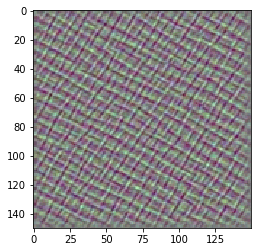

In [8]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

origin_img = input_img_data[0]
precessed_img = deprocess_image(origin_img)

plt.imshow(precessed_img)

**对所有卷积核进行可视化**

将前面的步骤整合在一起，对所有卷积核进行可视化。

In [9]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = layer.output
    
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    # start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)


def visualize_conv_kernel(model, layer_name):
    layer = model.get_layer(layer_name)
    size = 32
    margin = 2
    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')
    for i in range(8): # iterate over the rows of our results grid
        for j in range(8): # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    
    # Display the results grid
    plt.figure(figsize=(12, 12))
    plt.imshow(results)

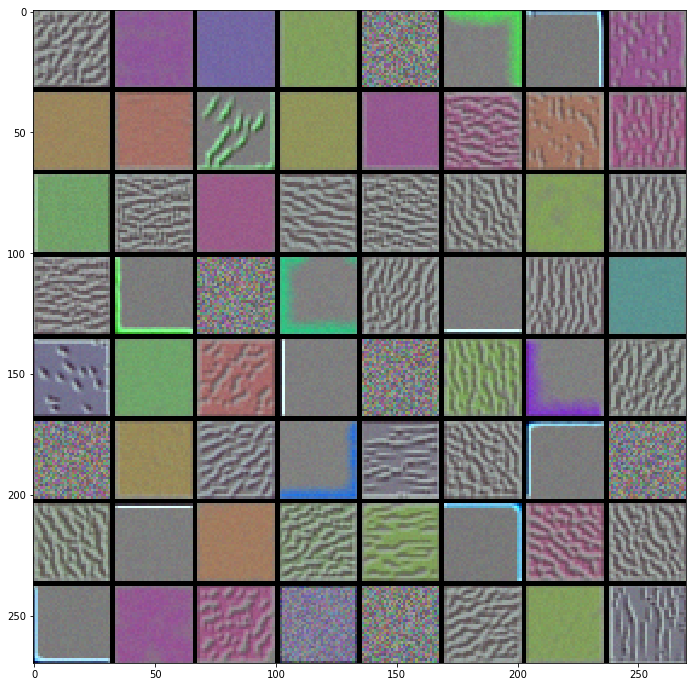

In [29]:
visualize_conv_kernel(model, 'block1_conv1')

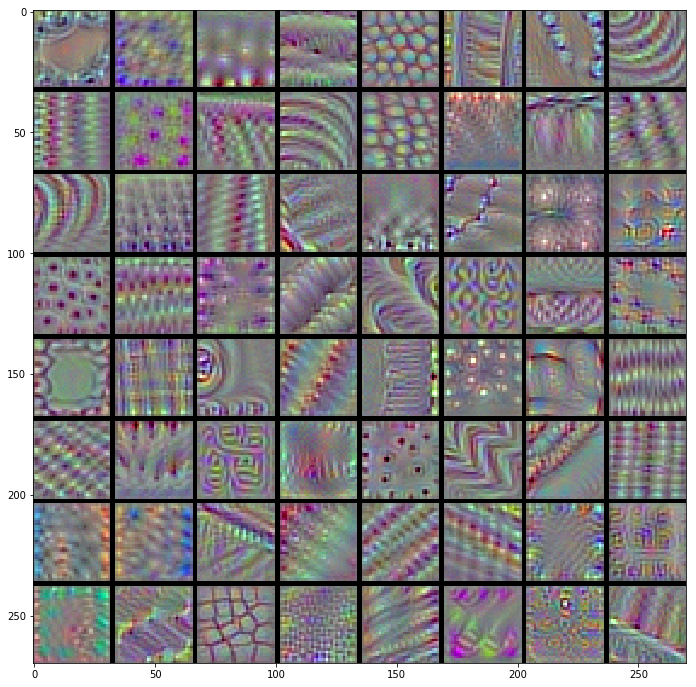

In [11]:
visualize_conv_kernel(model, 'block3_conv3')